# Lab. 3: GD, Newton methods and BFGS

## Introduction

#### <u>The goal of this laboratory is to study the application of local search algorithms on different benchmark functions.</u>

We will study three methods:
- *Gradient Descent*
- *Newton methods*
- *BFGS*

Moreover, we will study how their parameters change the behavior of these algorithms.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the trend of the points visited by the local search (use with 1d function)
5.   *trend*: show the best points find during the optmization process.

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or printing *dir(bf)*.

#### Base code to run every time the runtime is reconnected

In [72]:
%%capture

try:
  import benchmark_functions as bf
  import numdifftools as nd
except:  # colab env
  !pip install benchmark_functions
  !pip install numdifftools
  import benchmark_functions as bf
  import numdifftools as nd

from scipy.optimize import minimize, rosen, approx_fprime
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.misc import derivative
import inspect

plt.rcParams["figure.figsize"] = (8,5)

In [73]:
class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []

    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        """
        Returns a list of Optimum objects of the known global minima. If there aren't any minima, an empty list value will be returned instead;

        Returns:
        - List of objects of class "benchmark_functions.functions_info_loader.Optimum"
        - For each object:
          - Access to 'position' parameter to get the axis values
          - Access to 'score' parameter to get the value of the function
        """
        return self.f.minima()

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata[0], ydata[0], "Xr", markersize=13)
            plt.plot(xdata, ydata, "or-", markersize=5, linewidth=1.5)
            plt.plot(xdata[-1], ydata[-1], "Pr", markersize=13)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score

        plt.plot(values, label="trend of found points")

        plt.axhline(min, color="r", label="optimum")
        plt.xlabel('Function evaluations')
        plt.ylabel('f(x)')
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

    def gradient(self, x):
      return approx_fprime(x, self.f, epsilon=1.4901161193847656e-08)

def gradient_descent(f, x0, learn_rate, n_iter=50, tolerance=1e-06):
    x = x0
    f.history.append([v for v in x])
    for _ in range(n_iter):
        diff = -learn_rate * f.gradient(x)
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append([v for v in x])

    return x

def newton_method(f, x0, n_iter=50, tolerance=1e-06):
    x = np.array(x0)
    f.history.append(x.copy())
    f_jacob = nd.Jacobian(f.f)
    f_hess = nd.Hessian(f.f)
    for _ in range(n_iter):
        JA = f_jacob(x)
        HA = np.linalg.inv(f_hess(x))
        diff = -1*(JA.dot(HA)[0])
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append(x.copy())
    return x


def bfgs(f: OptFun, x0, eps: float, maxiter: int):
     """
     Optimizes a function by using the BFGS algorithm.

     - f: function to optimize, an instance of OptFun
     - x0: starting point for the search process
     - eps: step size for the update of the jacobian
     - maxiter: maximum number of iterations
     """
     return minimize(
         f,
         x0,
         method='L-BFGS-B',
         jac=None,
         options={
             'gtol': 1e-05,
             'norm': float('inf'),
             'eps': eps,
             "maxiter": maxiter,
             'disp': False,
             'return_all': True,
             'finite_diff_rel_step': None
         }
     )

In [74]:
def printClassInitArgs(class_obj):
    print(f'{class_obj.name()}')
    signature = inspect.signature(class_obj.__init__).parameters
    print("-------------------------------")
    for name, parameter in signature.items():
        if name != 'opposite':
            print("Name: ", name, "\nDefault value:", parameter.default)
            #print("Annotation:", parameter.annotation, "\nKind:", parameter.kind)
            print("-------------------------------")

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- What is the difference in search cost (the number of function/derivative evaluations) between these methods?
- Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?

In [75]:
# BE AWARE: check the arguments each benchmark function takes
# if you're not sure, you can check the arguments by using the printClassInitArgs function

printClassInitArgs(bf.Hypersphere())

Hypersphere
-------------------------------
Name:  n_dimensions 
Default value: 2
-------------------------------


## Exercise 1/3: GRADIENT DESCENT
In this first exercise, we will focus on the Gradient Descent algorithm.
The gradient descent function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *learn_rate*: the learning rate
4.   *n_iter*: maximum number of iterations
5.   *tolerance*: the tolerance for finding the optimum (minimum step to move towards the optimum, if the step is lower than this threshold, the search stops)

### Questions
- How does the Learning Rate influence optimization? 

Il tasso di apprendimento, o learning rate, svolge un ruolo critico nell'ottimizzazione tramite il gradient descent. Se impostato troppo basso, il modello compie passi molto piccoli durante l'ottimizzazione, rallentando significativamente la convergenza e richiedendo un elevato numero di iterazioni per raggiungere l'ottimo desiderato. Al contrario, un learning rate troppo alto può provocare oscillazioni intorno all'ottimo o persino impedire la convergenza, poiché i passi sono troppo grandi e il modello salta oltre il punto di minimo. Pertanto, è cruciale trovare un bilanciamento ottimale del learning rate: abbastanza piccolo da consentire una convergenza rapida ma non così piccolo da rallentare eccessivamente il processo. Questa scelta dipende anche dalla complessità della funzione da ottimizzare. Per esempio, nell'ottimizzazione della funzione ipersferica, con un numero fisso di 80 iterazioni, un learning rate troppo piccolo può rendere l'algoritmo troppo lento, richiedendo un numero eccessivo di iterazioni per convergere. Addirittua, riducendo il numero di iterazioni a 40, si nota che con un learning rate di 0.01 il valore minimo ottenuto è -1.7.
Per funzioni più complesse come la funzione di Ackley, è necessario utilizzare learning rate più grandi, poiché con valori troppo bassi l'algoritmo potrebbe rimanere bloccato nel punto di partenza. La presenza di molteplici minimi nella funzione di Ackley rende il gradient descent particolarmente difficile da convergere.


The learning rate plays a critical role in optimization through gradient descent. If set too low, the model takes very small steps during optimization, significantly slowing down convergence and requiring a high number of iterations to reach the desired optimum. Conversely, a learning rate that is too high can cause oscillations around the optimum or even prevent convergence altogether, as the steps are too large and the model jumps past the minimum point. Therefore, it is crucial to find an optimal balance for the learning rate: small enough to allow rapid convergence but not so small as to excessively slow down the process. This choice also depends on the complexity of the function being optimized. For example, in the optimization of the hyperspherical function, with a fixed number of 80 iterations, a learning rate that is too small can make the algorithm too slow, requiring an excessive number of iterations to converge. Moreover, reducing the number of iterations to 40, it is observed that with a learning rate of 0.01, the minimum value obtained is -1.7. For more complex functions like the Ackley function, larger learning rates are necessary, as too low values may cause the algorithm to remain stuck at the starting point. The presence of multiple minima in the Ackley function makes gradient descent particularly difficult to converge.


- How does tolerance influence the search?
Tolerance is the threshold above which I accept improvement. With lower tolerances, I accept many more points, whereas with higher tolerances, I will make larger leaps because I need a greater improvement to move to the next point.

- Are the effects of these parameters the same across different functions?
Yes, the effects of these parameters can vary across different functions. For more complex functions, higher learning rates are often required to prevent getting stuck in local minima or saddle points. However, for simpler functions, such high learning rates may lead to oscillations without convergence. Additionally, in the case of multimodal functions, having a slightly higher tolerance can help escape from local minima.

Si, per funzioni più complesse ho bisogno di learnign rate più alti perchè se non va a finire che mi fisso in minimi locali o in punti di sella, per funzioni più semplici invece learning rate così alti mi fanno saltare a destra e sinistra senza convergere. Se hai funzioni multimodal, una tolleranza un po' più alta ti permette di sfuggire dai minimi locali. 

In [76]:

change_lr = False
change_tolerance = False
hypersphere = False
ackley = False
  
lr = 0.1 # TODO: try different values of learning rate
n_iter = 120  # TODO: try different values of number of iterations
tolerance = 0.0001 # TODO: try different values of tolerance

if change_lr == True:
    lr_list = [0.01, 0.1, 0.5, 0.8]
    print('CHANGE LEARNING RATE: \n')
    for lr in lr_list:
        print('learning rate = ', lr)
        if hypersphere == True:
            bench_func = bf.Hypersphere(n_dimensions=2)  # TODO: try differenct benchmark function
            func = OptFun(bench_func)
            x0 = [-4, -4] # set appropriate to the benchmark function, TODO: try different starting points
        if ackley == True:
            bench_func = bf.Ackley(n_dimensions=2)  # TODO: try differenct benchmark function
            func = OptFun(bench_func)
            x0 = [-29, -29] # set appropriate to the benchmark function, TODO: try different starting points
        print("Bounds:", func.bounds())
        res = gradient_descent(func, x0, lr, n_iter, tolerance)
        print("Best location:", res)

        func.heatmap()
        func.plot()


if change_tolerance == True:
    tolerance_list =[ 0.0001, 0.001, 0.1, 1 ]
    print('CHANGE TOLERANCE: \n')
    for tolerance in tolerance_list:
        print('tolerance = ', tolerance)
        if hypersphere == True:
            bench_func = bf.Hypersphere(n_dimensions=2)  # TODO: try differenct benchmark function
            func = OptFun(bench_func)
            x0 = [-4, -4] # set appropriate to the benchmark function, TODO: try different starting points
        if ackley == True:
            lr = 0.5
            bench_func = bf.Ackley(n_dimensions=2)  # TODO: try differenct benchmark function
            func = OptFun(bench_func)
            x0 = [-29, -29] # set appropriate to the benchmark function, TODO: try different starting points
        print("Bounds:", func.bounds())
        res = gradient_descent(func, x0, lr, n_iter, tolerance)
        print("Best location:", res)

        func.heatmap()
        func.plot()

## Exercise 2/3: NEWTON METHOD
In this exercise, we will see the Newton method.
The Newton Method function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *n_iter*: maximum number of iterations
4.   *tolerance*: the tolerance for finding the optimum (minimum step to move towards the optimum, if the step is lower than this threshold, the search stops)

### Questions
- Is it faster to converge with respect to GD?

Si, in quanto tiene in considerazione anche le derivate seconde e di conseguenza sceglie, sull abase delle derivate seocnde, lo step size. Per funzioni convesse (guarda ipersfpera) è in grado di converere con un'unico step.
Questo succede perchè, introducendo le derivate seconde nel metodo di Newton significa considerare non solo la pendenza della funzione (derivata prima), ma anche come questa pendenza stessa cambia (derivata seconda). Utilizzando questa informazione, il metodo di Newton può "adattare" meglio i suoi passi di ottimizzazione in base alla forma locale della funzione. Posso in questo odo determinare lo step size andando a calcolare il rapporto tra la derivata prima e la derviata seconda. 
Nel caso di funzioni quadratiche, l'algoritmo convergerà in un'unico step in quanto l'ampiezza del salto, a presceindere da qual'è il punto di partenza, dipende solo dalla derivata prima poichè la derivata secnda è costante in tutti i punti. E converge in un'unico salto a prescinderre da quale sia la tolleranza (ovviamnete deve essere minore della distanza tra x0 e il minimo)

- How does tolerance influence the search?

Per funzioni quadratiche la tolleranza, se più piccola della distanza tra il punto di partenza e il minimo, nn influisce. Mentre per fnzioni multimodali l'algoritmo si stabilizza in minimi locali e non riesce ad uscire da lì, a prescindere di quale sia il valore di tolleranza e il numero di iterazioni

- Are the results similar across different functions?


In [77]:
change_tolerance = True
hypersphere = False
ackley = False

x0 = [-4.,-4.]  # set appropriate to the benchmark function, TODO: try different starting points
n_iter = 1000  # TODO: try different values of number of iterations
tolerance = 3.9  # TODO try different values of tolerance

if ackley == True:
    if change_tolerance == True:
        tolerance_list =[ 0.000001, 0.00001, 0.001, 0.01 ]
        print('CHANGE TOLERANCE: \n')
        for tolerance in tolerance_list:
            print('tolerance = ', tolerance)          
            bench_func = bf.Ackley(n_dimensions=2)  # TODO: try differenct benchmark function
            func = OptFun(bench_func)
            x0 = [-29, -29] # set appropriate to the benchmark function, TODO: try different starting points
            print("Bounds:", func.bounds())
            res = gradient_descent(func, x0, lr, n_iter, tolerance)
            print("Best location:", res)
            func.heatmap()
            func.plot()



if hypersphere == True:
    bench_func = bf.Hypersphere(n_dimensions=2)  # TODO: try differenct benchmark function
    func = OptFun(bench_func)
    print("Bounds:", func.bounds())
    res = newton_method(func, x0, n_iter, tolerance)
    print("Best location:", res)
    func.heatmap()
    func.plot()

## Exercise 3/3: BFGS OPTIMIZATION
In this exercise, we will focus on the BFGS optimization algorithm.
The BFGS function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *eps*: step size for the update of the jacobian
4.   *max_iter*: maximum number of iterations

### Questions
- What does it happen by varying these parameters?

Il parametro eps introduce una perturbazione nell'approssimazione della matrice Hessiana. (Guarda psudocodice) Calcola s = (xk+eps -xk) /eps. 
Permette a funzioni multimodali di slatare fuori dai minimi locali ma comunque fa fatica ad andare in centro 

- How do they influence the evolution process?
- What is the difference between BFGS and L-BFGS? Hint: you have to change the BFGS function, calling the right method to minimize. See [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb) the parameters available.

eps =  0.01
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.939448905092483
Best location: [-29. -29.]


C:\Users\carlo\AppData\Local\Temp\ipykernel_8128\396274451.py:117: RuntimeWarning: Method L-BFGS-B does not support the return_all option.
  return minimize(
C:\Users\carlo\AppData\Local\Temp\ipykernel_8128\396274451.py:117: OptimizeWarning: Unknown solver options: norm, return_all
  return minimize(


<Figure size 800x500 with 0 Axes>

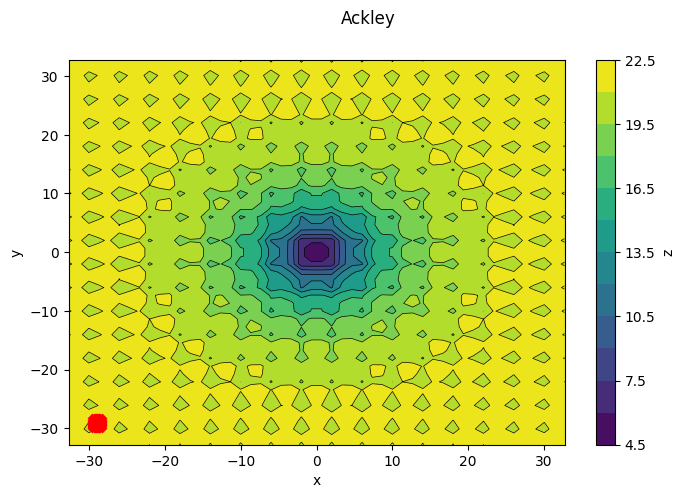

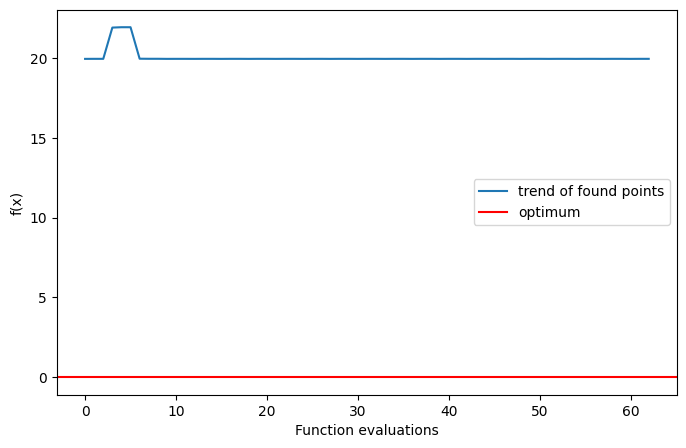

eps =  0.1
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.939448905092483
Best location: [-29. -29.]


<Figure size 800x500 with 0 Axes>

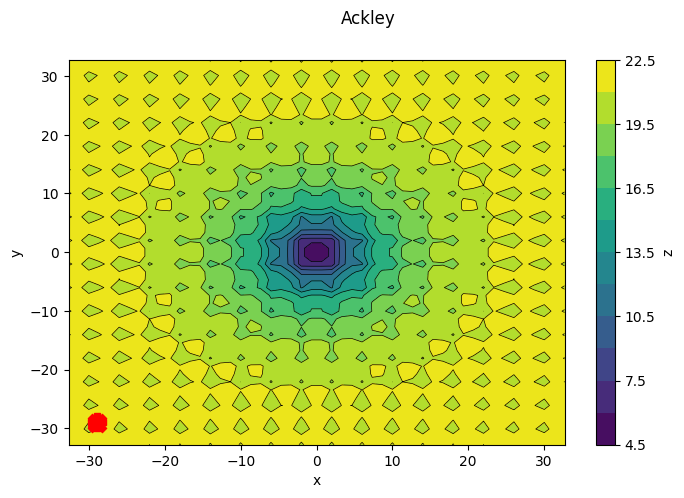

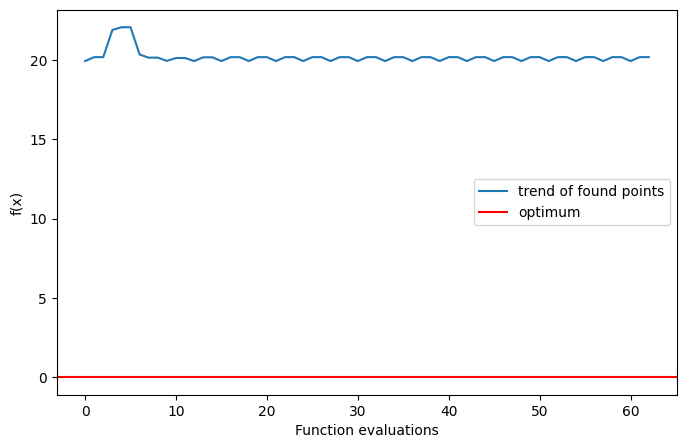

eps =  1
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.93944822180192
Best location: [-28.99988631 -28.99988631]


<Figure size 800x500 with 0 Axes>

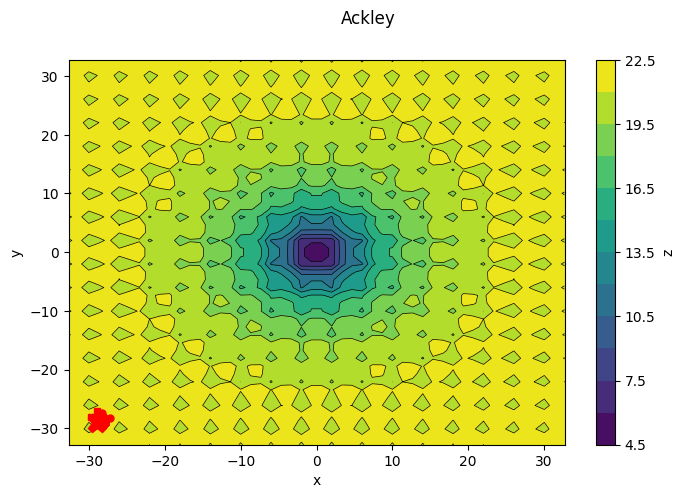

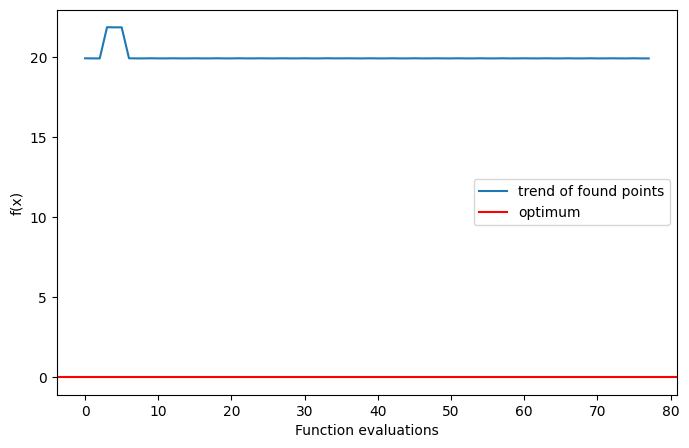

eps =  10
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.939448234954238
Best location: [-28.99987147 -28.99987147]


<Figure size 800x500 with 0 Axes>

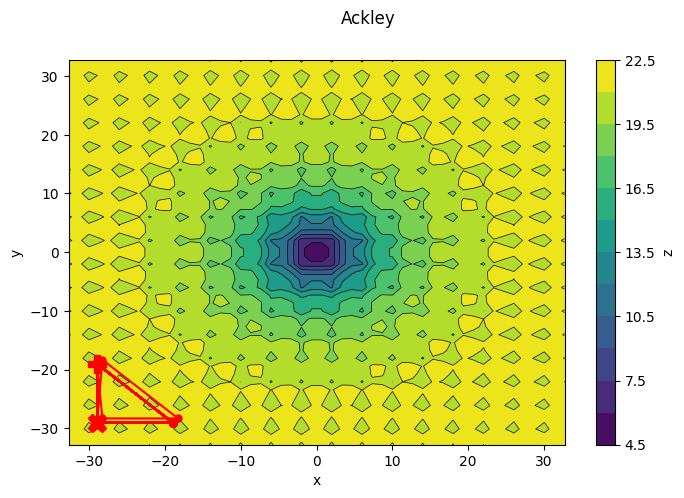

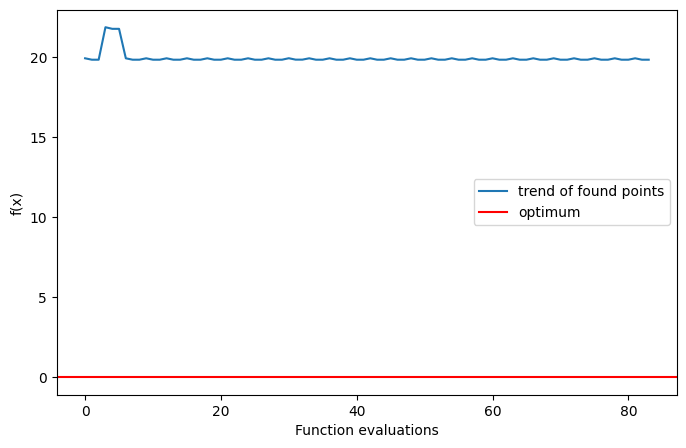

eps =  20
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.93944822176381
Best location: [-28.99988716 -28.99988716]


<Figure size 800x500 with 0 Axes>

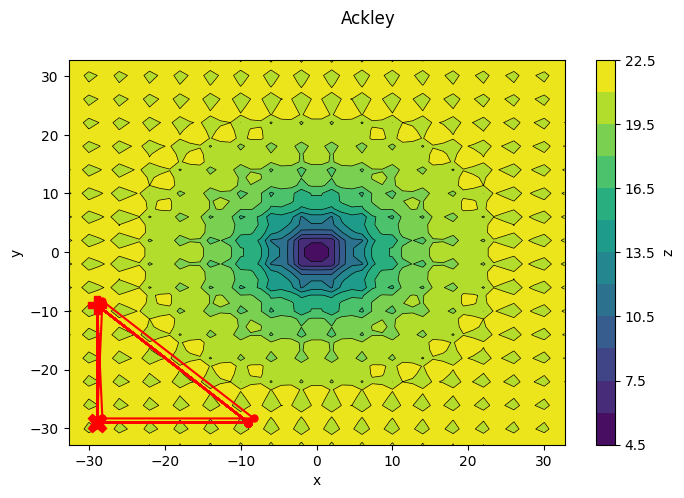

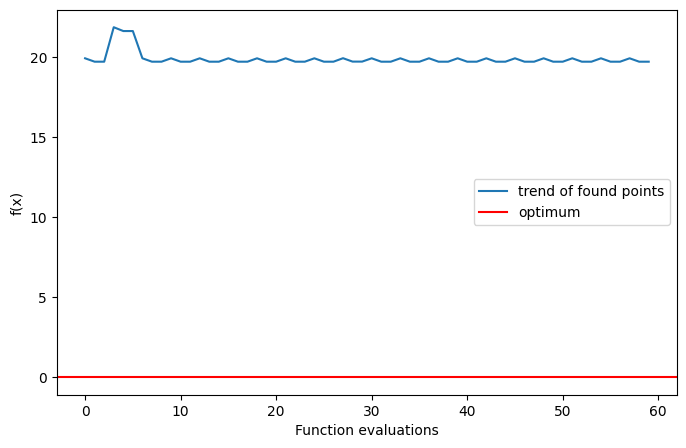

eps =  0.01
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.939448905092483
Best location: [-29. -29.]


<Figure size 800x500 with 0 Axes>

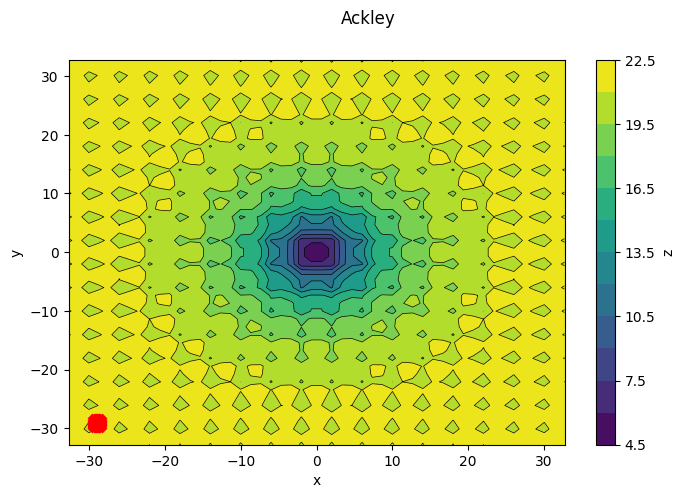

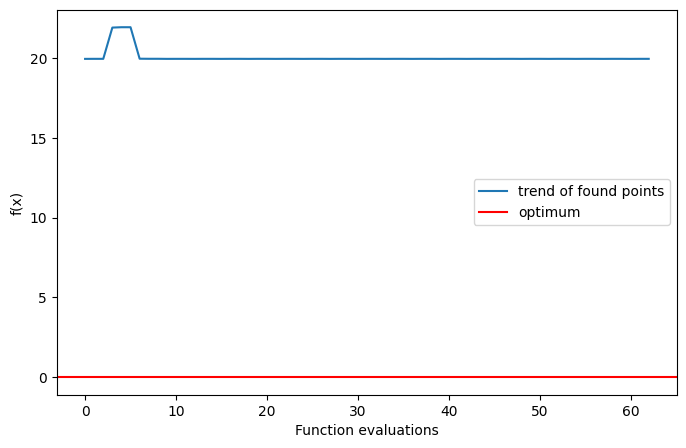

eps =  0.1
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.939448905092483
Best location: [-29. -29.]


<Figure size 800x500 with 0 Axes>

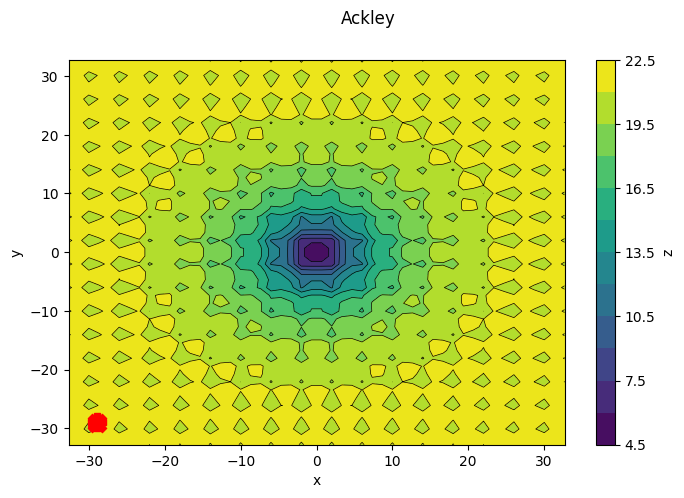

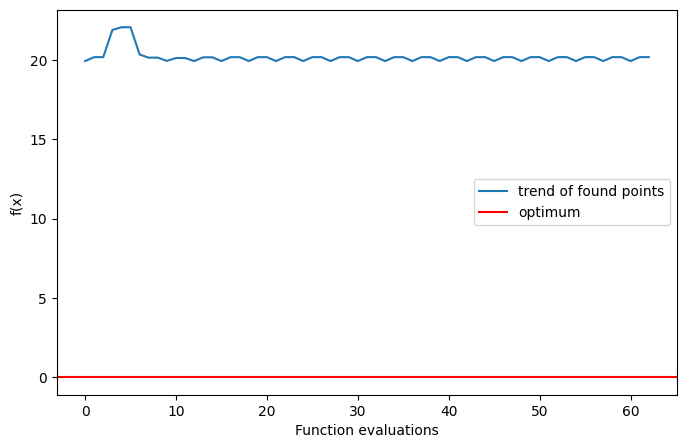

eps =  1
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.93944822180192
Best location: [-28.99988631 -28.99988631]


<Figure size 800x500 with 0 Axes>

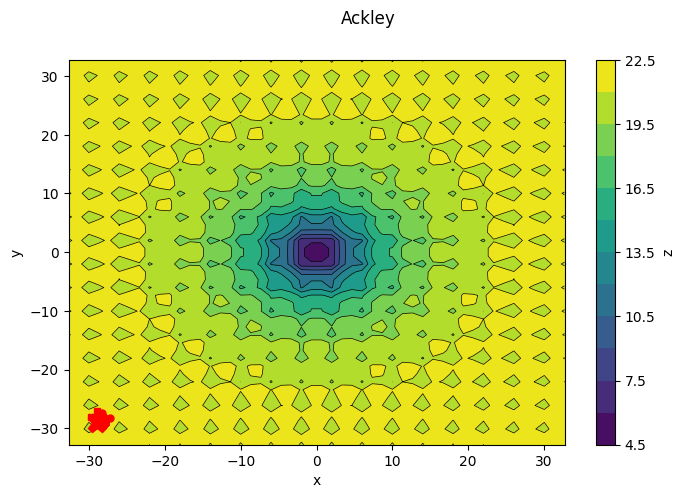

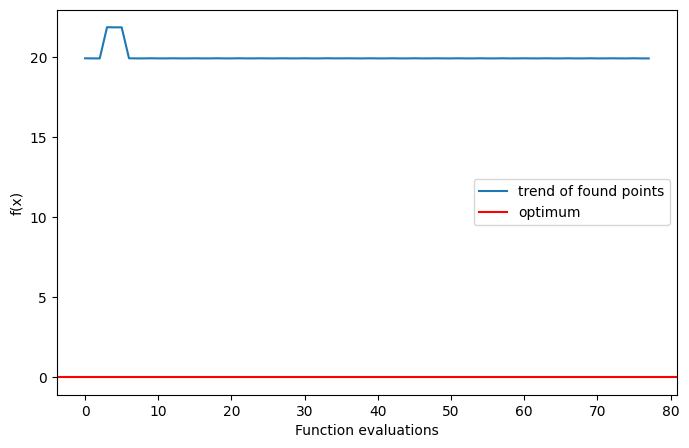

eps =  10
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.939448234954238
Best location: [-28.99987147 -28.99987147]


<Figure size 800x500 with 0 Axes>

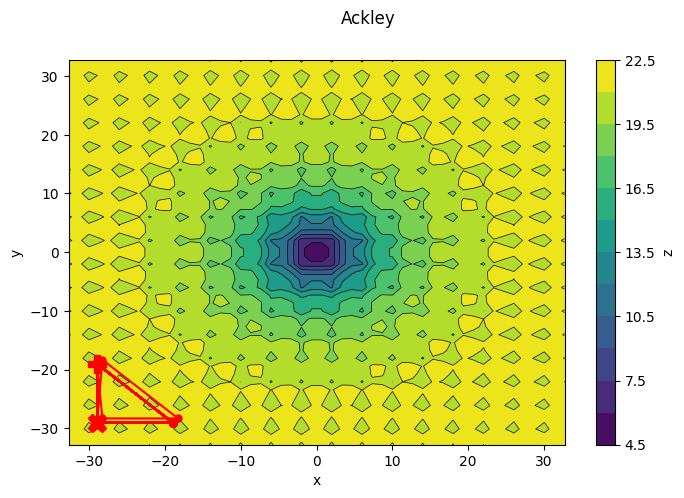

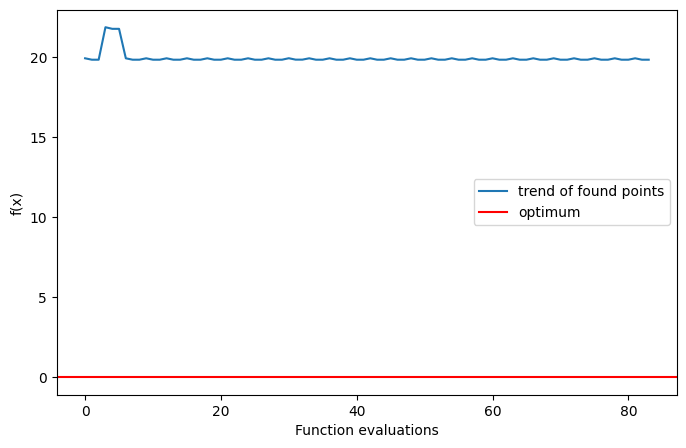

eps =  20
Bounds: [(-32.768, 32.768), (-32.768, 32.768)]
Best value: 19.93944822176381
Best location: [-28.99988716 -28.99988716]


<Figure size 800x500 with 0 Axes>

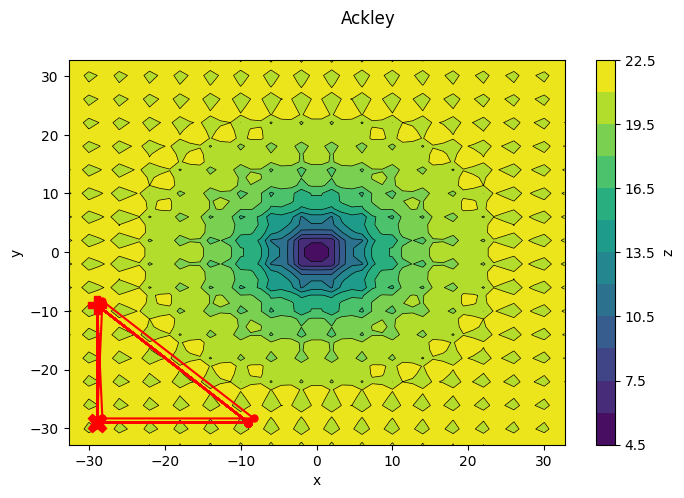

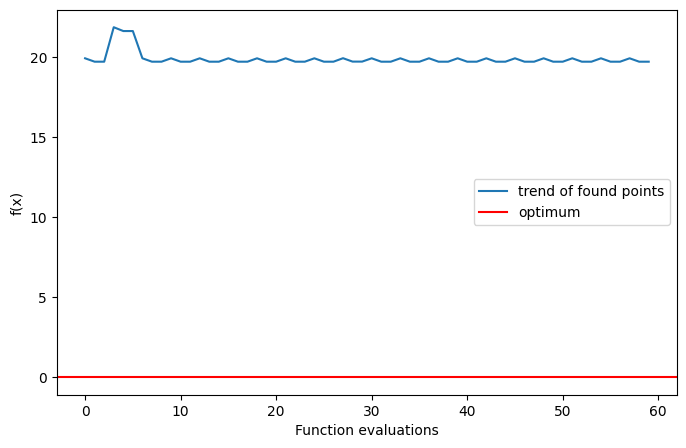

In [78]:

x0 = [-29., -29.]  # set appropriate to the benchmark function
eps_list = [0.01, 0.1, 1, 10, 20]  # TODO: try different values
maxiter = 200  # TODO: try differeent values

for eps in eps_list:
    print('eps = ', eps)
    bench_func = bf.Ackley(n_dimensions=2)  # TODO: try differenct benchmark function
    func = OptFun(bench_func)
    print("Bounds:", func.bounds())
    res = bfgs(func, x0, eps, maxiter)
    best_value, best_location = res['fun'], res['x']
    print("Best value:", best_value)
    print("Best location:", best_location)

    func.heatmap()
    func.plot()

x0 = [-29., -29.]  # set appropriate to the benchmark function
eps_list = [0.01, 0.1, 1, 10, 20]  # TODO: try different values
maxiter = 200  # TODO: try differeent values

for eps in eps_list:
    print('eps = ', eps)
    bench_func = bf.Ackley(n_dimensions=2)  # TODO: try differenct benchmark function
    func = OptFun(bench_func)
    print("Bounds:", func.bounds())
    res = bfgs(func, x0, eps, maxiter)
    best_value, best_location = res['fun'], res['x']
    print("Best value:", best_value)
    print("Best location:", best_location)

    func.heatmap()
    func.plot()

## Final questions
- What is the difference in search cost (the number of function/derivative evaluations) between these methods?
- Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?  

In [79]:
# TODO